In [25]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import glob
import cv2
import os
import PIL
import keras
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import metrics
from sklearn.model_selection import train_test_split
#from keras.utils import Normalize
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Dense,Flatten
import tensorflow as tf
import numpy as np
from keras.layers  import BatchNormalization

from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from keras.layers import Dense,Dropout,Activation,Flatten,GlobalAveragePooling2D
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


In [2]:
dataset = []
label= []

image_directory='tejasdataset/Training/'
glioma_image=os.listdir(image_directory+ 'glioma/')
meningioma_image=os.listdir(image_directory+ 'meningioma/')
notumor_image=os.listdir(image_directory+ 'notumor/')
pituitary_image=os.listdir(image_directory+ 'pituitary/')
for i , image_name in enumerate(glioma_image):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'glioma/'+image_name)
        if image is not None:
            image=PIL.Image.fromarray(image, "RGB")
            image=image.resize((64,64))
            dataset.append(np.array(image))
            label.append(0)
for i , image_name in enumerate(meningioma_image):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'meningioma/'+image_name)
        if image is not None:
            image=PIL.Image.fromarray(image, "RGB")
            image=image.resize((64,64))
            dataset.append(np.array(image))
            label.append(1)
for i , image_name in enumerate(notumor_image):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'notumor/'+image_name)
        if image is not None:
            image=PIL.Image.fromarray(image, "RGB")
            image=image.resize((64,64))
            dataset.append(np.array(image))
            label.append(2)          
for i , image_name in enumerate(pituitary_image):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'pituitary/'+image_name)
        if image is not None:
            image=PIL.Image.fromarray(image, "RGB")
            image=image.resize((64,64))
            dataset.append(np.array(image))
            label.append(3)                                                
dataset=np.array(dataset)                
label=np.array(label)
print(len(dataset))
print(len(label))

4416
4416


[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                               

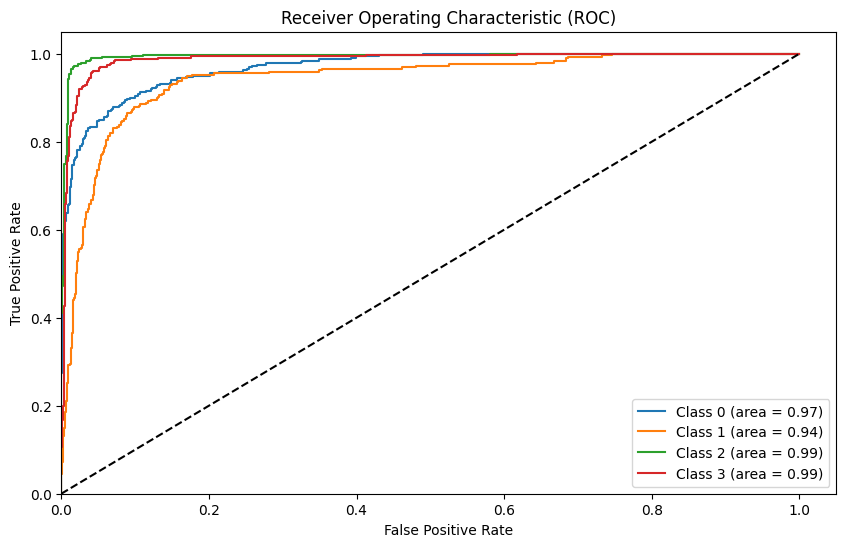

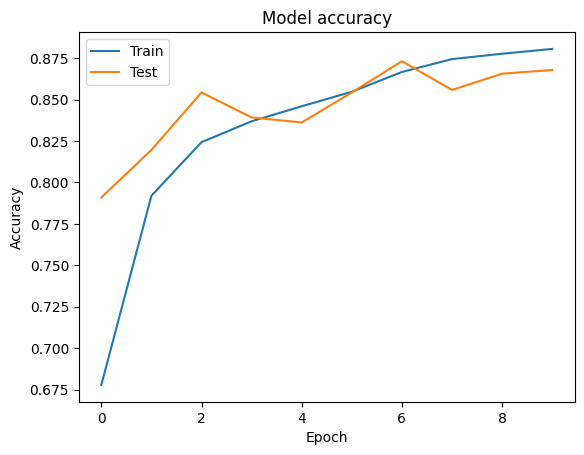

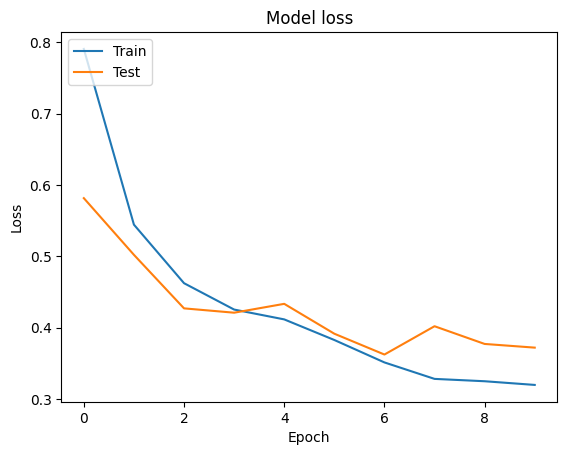

Test loss: 0.37181222438812256 / Test accuracy: 0.8679245114326477
42/42 [==============================] - 46s 1s/step


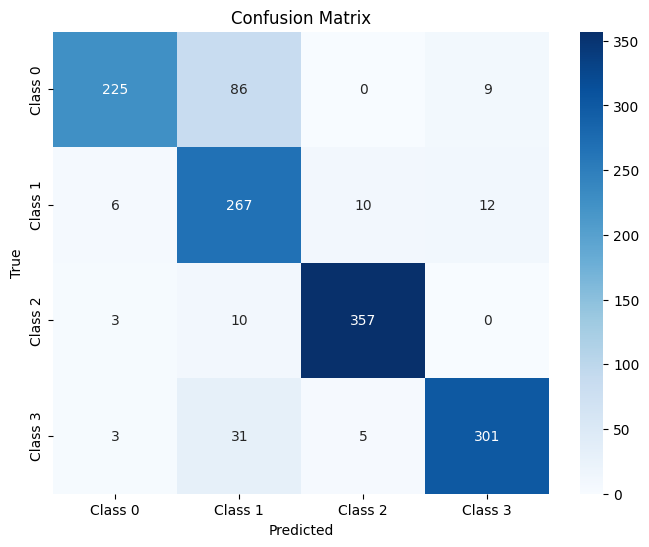

In [4]:
x_train,x_test,y_train,y_test=train_test_split(dataset,label,test_size=0.3,random_state=0)

x_train=tf.keras.utils.normalize(x_train,axis=1)
x_test=tf.keras.utils.normalize(x_test,axis=1)

y_train=tf.keras.utils.to_categorical(y_train)
y_test=tf.keras.utils.to_categorical(y_test)
print(y_test)
IMAGE_SIZE=[64,64]


vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#avoiding extra training parameters
for layer in vgg.layers:
    layer.trainable = False
num_classes=4
# ...
def lw(bottom_model, num_classes, dropout_rate=0.2, units=768):  # Use the best hyperparameter values
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(units, activation='relu')(top_model)  # Use the tuned 'units' value
    top_model = Dropout(dropout_rate)(top_model)  # Use the tuned 'dropout' value
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model
# ...
FC_head = lw(vgg, num_classes)

model = Model(inputs=vgg.input, outputs=FC_head)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hs = model.fit(x_train, y_train,
               batch_size=32, verbose=1, epochs=10,
               validation_data=(x_test, y_test),
               shuffle=True)
from sklearn.metrics import roc_curve, auc

# Predict probabilities for test set
y_pred_probs = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
# Plot training & validation accuracy values
plt.plot(hs.history['accuracy'])
plt.plot(hs.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hs.history['loss'])
plt.plot(hs.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for the test set
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
model.save("multi1_hyper_tuned.h5")


In [15]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model(r'multi1_hyper_tuned.h5')

# Load and preprocess a new image
image_path = r"tejasdataset/Training/pituitary/Tr-pi_0337.jpg"  # Replace with the actual path to your image
image = cv2.imread(image_path)
image = cv2.resize(image, (64, 64))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.expand_dims(image, axis=0)
image = image / 255.0  # Normalize the image

# Make a prediction
predictions = model.predict(image)

# Get the class label with the highest probabilitye
predicted_class = np.argmax(predictions[0])
class_labels = ["glioma", "meningioma", "notumor", "pituitary"]
predicted_label = class_labels[predicted_class]

print("Predicted class:", predicted_label)
print("Class probabilities:", predictions[0])


1/1 [==============================] - 0s 133ms/step
Predicted class: pituitary
Class probabilities: [0.00416045 0.48148534 0.01740051 0.4969537 ]


In [17]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [19]:
parkinsons_data = pd.read_csv('parkinsons.csv')

In [20]:
# Basic data exploration
print(parkinsons_data.head())
print(parkinsons_data.shape)
print(parkinsons_data.info())
print(parkinsons_data.isnull().sum())
print(parkinsons_data.describe())
print(parkinsons_data['status'].value_counts())
print(parkinsons_data.groupby('status').mean())

             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.0654

In [ ]:
X = parkinsons_data.drop(columns=['name','status'], axis=1)
Y = parkinsons_data['status']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
print(X.shape, X_train.shape, X_test.shape)

In [ ]:
model = svm.SVC(kernel='linear')
model.fit(X_train, Y_train)

In [ ]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print('Accuracy score of training data: ', training_data_accuracy)

In [ ]:
from sklearn.svm import SVC


In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

# Define the hyperparameters and their respective values to search
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"The best hyperparameters are: {best_params}")

# Get the best model
best_model_par = grid_search.best_estimator_

# Evaluate the model on the test set
test_data_accuracy = best_model_par.score(X_test, Y_test)
print(f'Accuracy score on test data with best model: {test_data_accuracy}')

In [ ]:
import pickle
filename = 'parkinson_disease_model.sav'
pickle.dump(best_model_par, open(filename, 'wb'))

In [ ]:
input_data = (197.07600,206.89600,192.05500,0.00289,0.00001,0.00166,0.00168,0.00498,0.01098,0.09700,0.00563,0.00680,0.00802,0.01689,0.00339,26.77500,0.422229,0.741367,-7.348300,0.177551,1.743867,0.085569)
len(input_data)
# changing input data to a numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the numpy array
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = model.predict(input_data_reshaped)
print(prediction)


if (prediction[0] == 0):
  output_parkinson="The Person does not have Parkinsons Disease"

else:
  output_parkinson="The Person has Parkinsons"

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
heart_data = pd.read_csv('heart.csv')

In [ ]:
heart_data.head()
heart_data.shape
heart_data.info()
heart_data.isnull().sum()
heart_data['target'].value_counts()


In [ ]:
X = heart_data.drop(columns='target', axis=1)
Y = heart_data['target']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

# Define the hyperparameters to search
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
model_heart = LogisticRegression()
model_heart.fit(X_train, Y_train)
X_train_prediction = model_heart.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy on Training data : ', training_data_accuracy)
X_test_prediction = model_heart.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy on Test data : ', test_data_accuracy)
import pickle
filename = 'heart_disease_model.sav'
pickle.dump(model_heart, open(filename, 'wb'))
input_data = (62,0,0,140,268,0,0,160,0,3.6,0,2,2)

# change the input data to a numpy array
input_data_as_numpy_array= np.asarray(input_data)

# reshape the numpy array as we are predicting for only on instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = model_heart.predict(input_data_reshaped)
print(prediction)

if (prediction[0]== 0):
  output_heart='The Person does not have a Heart Disease'
else:
  output_heart='The Person has Heart Disease'

In [ ]:
diabetes_dataset = pd.read_csv('diabetes.csv')

In [ ]:
diabetes_dataset.head()
diabetes_dataset.shape
diabetes_dataset['Outcome'].value_counts()
diabetes_dataset.groupby('Outcome').mean()
X = diabetes_dataset.drop(columns = 'Outcome', axis=1)
Y = diabetes_dataset['Outcome']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, stratify=Y, random_state=2)
print(X.shape, X_train.shape, X_test.shape)
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train, Y_train)
X_train_prediction = classifier.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)
print('Accuracy score of the training data : ', training_data_accuracy)
X_test_prediction = classifier.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)
print('Accuracy score of the test data : ', test_data_accuracy)

In [ ]:
input_data = (5,166,72,19,175,25.8,0.587,51)

# changing the input_data to numpy array
input_data_as_numpy_array = np.asarray(input_data)

# reshape the array as we are predicting for one instance
input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

prediction = classifier.predict(input_data_reshaped)
print(prediction)

if (prediction[0] == 0):
  output_diabetic='The person is not diabetic'
else:
  output_diabetic='The person is diabetic'

In [ ]:
import pickle
filename = 'diabetes_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open('diabetes_model.sav', 'rb'))

In [ ]:
adf = pd.read_csv('Hemoglobin.csv')

In [ ]:
adf.head()


In [ ]:
adf.columns

In [ ]:
# List of columns to drop
columns_to_drop = ["Age", "Gender", "Family History of Diabetes", "Smoking", "Diet", "Exercise"]

# Drop the specified columns
adf = adf.drop(columns=columns_to_drop)

# Print the modified DataFrame
adf.head()

In [ ]:
adf.isnull().sum()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
# Encode categorical variables (if any)
label_encoder = LabelEncoder()
adf['Blood Pressure'] = label_encoder.fit_transform(adf['Blood Pressure'])

# Define features (X) and target (y)
X = adf[['BMI', 'Blood Pressure', 'FBS', 'HbA1c']]
y = adf['Diagnosis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using Random Forest
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

# Initialize and train the Support Vector Machine Classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict using Support Vector Machine
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)

# Compare accuracies
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"SVM Accuracy: {svm_accuracy:.2f}")


In [ ]:
new_data = {
    'BMI': float(input('Enter BMI: ')),
    'Blood Pressure': label_encoder.transform([input('Enter Blood Pressure (Normal/High): ')])[0],
    'FBS': float(input('Enter FBS: ')),
    'HbA1c': float(input('Enter HbA1c: '))
}

# Prepare the data for prediction
new_data = [[new_data['BMI'], new_data['Blood Pressure'], new_data['FBS'], new_data['HbA1c']]]

svm_predicted_diagnosis = svm_model.predict(new_data)
#25,Normal,100.5.7

# Print the predicted diagnosis
output_hemo=svm_predicted_diagnosis[0]
if output_hemo=="No":output_hemo="NO diagnosis needed, blood is normal"
if output_hemo=="Yes":output_hemo="Diagnosis needed, there is some problem in blood"

In [ ]:
cdk=pd.read_csv('hypothyroid.csv')

In [ ]:
cdk.head()

In [ ]:
cdk=cdk.dropna()

In [ ]:
cdk.isnull().sum()

In [ ]:
cdk=cdk

In [ ]:
data=cdk.columns

In [ ]:
for i in range(len(data)-1):
  print(data[i])

In [ ]:
columns_to_drop=[  'age',
    'sex',
    'on thyroxine',
    'query on thyroxine',
    'on antithyroid medication',
    'sick',
    'pregnant',
    'thyroid surgery',
    'I131 treatment',
    'query hypothyroid',
    'query hyperthyroid',
    'lithium',
    'goitre',
    'tumor',
    'hypopituitary',
    'psych']
# Drop the specified columns
cdk = cdk.drop(columns=columns_to_drop)
cdk.head(10)

In [ ]:
cdk.columns

In [ ]:
numeric_columns = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
for col in numeric_columns:
    cdk[col] = pd.to_numeric(cdk[col], errors='coerce')

# Calculate column medians
medians = cdk[numeric_columns].median()

# Replace missing values with respective column medians
cdk.fillna(medians, inplace=True)

In [ ]:
cdk.head()

In [ ]:
cdk.isnull().sum()

In [ ]:
cdk=cdk.drop(columns=['TBG'])

In [ ]:
cdk.columns

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the dataset
data = cdk


data = data.replace({'t': 1, 'f': 0})

# Define features (X) and target (y)
X = data[['TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI', 'TBG measured']]
y = data['binaryClass']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model (Logistic Regression in this example)
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predict binaryClass on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


In [ ]:
import joblib
from sklearn.linear_model import LogisticRegression


# Save the model
joblib.dump(model, 'model.pkl')

# Load the model
loaded_model_hypothyroid = joblib.load('model.pkl')

In [ ]:
user_input = {}

# Define the features
features = ['TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI', 'TBG measured']

for feature in features:
    user_input[feature] = input(f'Enter value for {feature}: ')

# Convert user input to a DataFrame with a single row
user_data = pd.DataFrame([user_input])

# Encode 't' and 'f' as 1 and 0
user_data = user_data.replace({'t': 1, 'f': 0})

# Assuming your model uses the same features as before
X_user = user_data[['TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI', 'TBG measured']]
# Make a prediction using the loaded model
prediction = loaded_model_hypothyroid.predict(X_user)
#t,1.3,t,2.5,t,125,t,1.14,f,109,f,SVHC
# Print the prediction
output_thyroid=prediction[0]
if output_thyroid=="P":output_thyroid="thyrois symtom present"
if output_thyroid=="N":output_thyroid="no symtoms of thyroid"


In [ ]:
from rich.console import Console

console = Console()

def print_medical_report(parkinson, heart, diabetic, hemo, thyroid):
    console.print("\nMedical Report as per given input", style="bold underline")
    console.print("---------------")
    console.print(f"[bold]Parkinson:[/bold] {parkinson}")
    console.print(f"[bold]Heart Condition:[/bold] {heart}")
    console.print(f"[bold]Diabetic:[/bold] {diabetic}")
    console.print(f"[bold]Hemoglobin Level:[/bold] {hemo}")
    console.print(f"[bold]Thyroid Condition:[/bold] {thyroid}")

78

# Print the medical report
print_medical_report(output_parkinson, output_heart, output_diabetic, output_hemo, output_thyroid)

In [ ]:
print("\nMedical Report as per given input")
print("---------------")
print(output_parkinson)
print(output_heart)
print(output_diabetic)
print(output_hemo)
print(output_thyroid)